# **BUDT737 Enterprise Cloud Computing & Big Data: Group Project** <br>
### **MLifeBalance : Harmonizing Work and Life through PySpark and ML**
### **Team 501_4** : Aashay Zanpure & Harshil Patel, under the guidance of Prof. Bharti Motwani

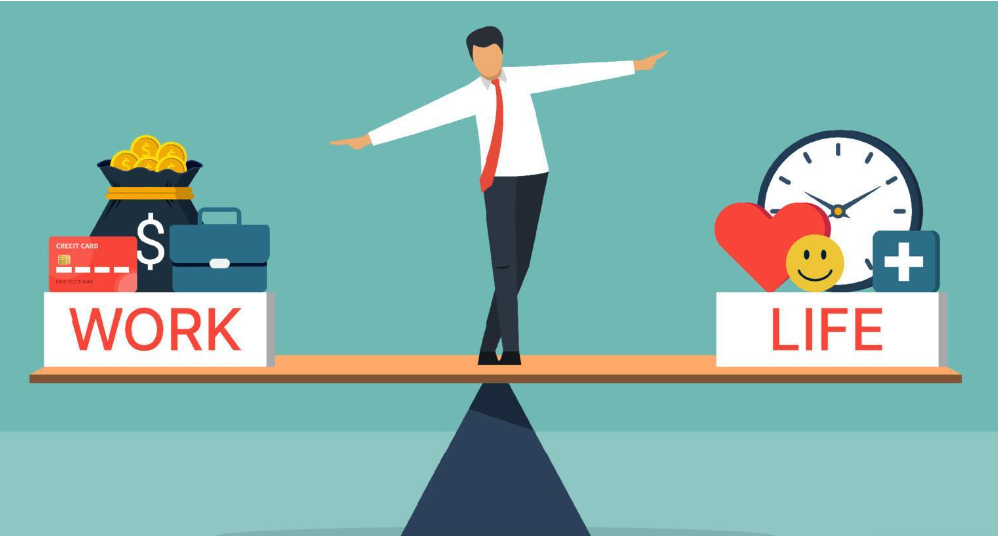

### **Table of Contents**

1. Introduction <br>
2. Research Questions <br>
3. About the Dataset <br>
4. Exploratory Data Analysis, Data Cleaning & Transformation <br>
5. Research Questions, Methodology & Solutions <br>
6. Conclusion and Future Scope <br>
7. Important Links

### **Introduction**

In today's fast-paced world, achieving equilibrium between work commitments and personal life is essential for individual health, happiness, and productivity. The MLifeBalance project makes an attempt to delve into this crucial domain, leveraging the power of PySpark ML to explore, analyze, and optimize the intricate dynamics between work and life. <br>
<br>
Through rigorous analysis of data, innovative methodologies, and a commitment to deriving actionable insights, the project aims to shed light on the complex interplay between work and life factors. <br>
<br>
The project's objectives include exploring various aspects of work-life balance, analyzing influential factors, and ultimately optimizing this balance to enhance the lives of individuals and the performance of organizations. By uncovering patterns, trends, and correlations within the data, the project strives to contribute valuable insights to the ongoing discourse on work-life harmony.

### **Research Questions**

[1] **Identifying Key Influencers:** <br>
Determining the top 5 factors that affect work-life balance scores using random forest classifier & performing a correlation analysis between some variables of the dataset.
<br><br>
[2] **Predictive Work-Life Balance Modeling:** <br>
Building a linear regression ML model to forecast work-life balance scores using diverse inputs.
<br><br>
[3] **Targeting Employees with Highest Potential:** <br>
Bucketizing employees based on their work life balance score, understanding who and what can be improved, and recommend a specific chunk of employees for personal attention to enhance them into a better employee.

### **About the Dataset**

**Source** : Kaggle (https://www.kaggle.com/datasets/ydalat/lifestyle-and-wellbeing-data) <br>
**Number of variables / columns** : 24 <br>
**Number of observations / rows** : ~16,000 <br>
**Data time period / duration** : July 2015 to March 2021 <br><br>
**Acknowledgements** : <br>
[1] Authentic-Happiness.com <br>
[2] 360living.co <br>
[3] guidebienetre.org <br>
[4] UN Sustainable Developments Goals <br>
[5] https://www.greatplacetowork.com/

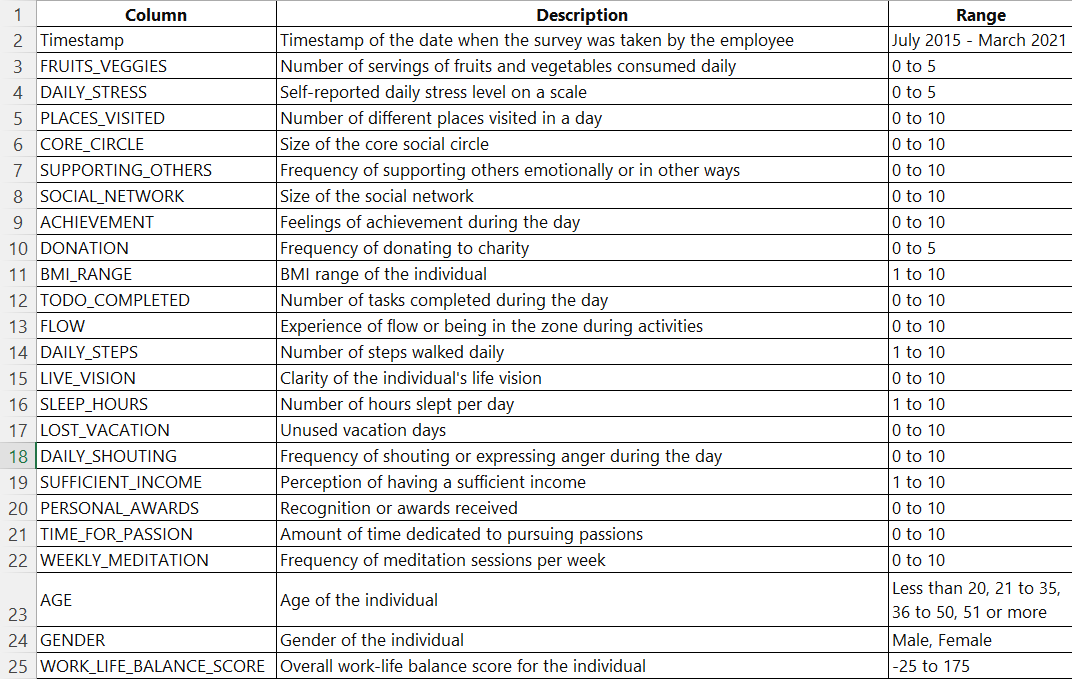

**NOTE:**

Daily Shouting, Lost Vacation, Daily Stress - Negative impact on the score <br>
Age, Gender - Varying impact on the score <br>
Rest of the columns - Positive impact on the score

### **EDA, Data Cleaning & Transformation**

In [ ]:
# Installing the required libraries
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=bcba6b9548a7749228f974afe564896e7677b3ee4d4380503c211976df395c61
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Importing the required libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
# Creating a spark session & importing the dataset
session=SparkSession.builder.appName("group_project").master("local").getOrCreate()
original_data=session.read.csv("Wellbeing_and_lifestyle_data_Kaggle.csv", header=True, inferSchema=True)

In [ ]:
#Changing the data type of a column
from pyspark.sql.types import IntegerType
original_data = original_data.withColumn("DAILY_STRESS", original_data["DAILY_STRESS"].cast(IntegerType()))

In [ ]:
original_data_len = original_data.count()

# Creating an list consisting of employee IDs
employee_id_list = []

In [ ]:
# for-loop to generate fictitious employee IDs starting from EMP_00001
for row in range(1, original_data_len + 1):
  if (row) < 10:
    employee_id_list.append('EMP_0000'+ str(row))
  elif (row) < 100:
    employee_id_list.append('EMP_000'+ str(row))
  elif (row) < 1000:
    employee_id_list.append('EMP_00'+ str(row))
  elif (row) < 10000:
    employee_id_list.append('EMP_0'+ str(row))
  elif (row) < 100000:
    employee_id_list.append('EMP_'+ str(row))

In [ ]:
# Creating a dataframe containing just the Employee IDs
employee_id_list_df = session.createDataFrame([(row,) for row in employee_id_list], ["EMPLOYEE_ID"])

In [ ]:
#Using 'monotonically_increasing_id' (inbuilt function) to generate employee IDs from 1 - 16k
employee_id_list_df = employee_id_list_df.withColumn("row_index", monotonically_increasing_id())
original_data = original_data.withColumn("row_index", monotonically_increasing_id())

In [ ]:
#Joining the employee_id with the rest of the data
final_data = employee_id_list_df.join(original_data, on="row_index", how="inner").drop("row_index")
final_data.show(3)

+-----------+-------------+--------------+------------+--------------+-----------+-----------------+--------------+-----------+--------+---------+--------------+----+-----------+-----------+-----------+-------------+--------------+-----------------+---------------+----------------+-----------------+------------+------+-----------------------+
|EMPLOYEE_ID|    Timestamp|FRUITS_VEGGIES|DAILY_STRESS|PLACES_VISITED|CORE_CIRCLE|SUPPORTING_OTHERS|SOCIAL_NETWORK|ACHIEVEMENT|DONATION|BMI_RANGE|TODO_COMPLETED|FLOW|DAILY_STEPS|LIVE_VISION|SLEEP_HOURS|LOST_VACATION|DAILY_SHOUTING|SUFFICIENT_INCOME|PERSONAL_AWARDS|TIME_FOR_PASSION|WEEKLY_MEDITATION|         AGE|GENDER|WORK_LIFE_BALANCE_SCORE|
+-----------+-------------+--------------+------------+--------------+-----------+-----------------+--------------+-----------+--------+---------+--------------+----+-----------+-----------+-----------+-------------+--------------+-----------------+---------------+----------------+-----------------+----------

In [ ]:
# Capitalizing every letter of the 'Timestamp' column
final_data = final_data.withColumnRenamed('Timestamp', 'TIMESTAMP')

In [ ]:
# Displaying general info w.r.t the dataset
print("Number of observations:", final_data.count())
print("Information of columns:\n", final_data.columns)
print("Description of columns:\n", final_data.describe().show())
print("First few records:\n", final_data.show(3))
final_data = final_data.na.drop()

Number of observations: 15971
Information of columns:
 ['EMPLOYEE_ID', 'TIMESTAMP', 'FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME', 'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE', 'GENDER', 'WORK_LIFE_BALANCE_SCORE']
+-------+-----------+-------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------+------+-----------------------+
|summary|EMPLOYEE_ID|    TIMESTAMP|    FRUITS_VEGGIES|      DAILY_STRESS|   PLACES_

In [ ]:
#Checking the final datatypes for each column
column_types = final_data.dtypes

for column, data_type in column_types:
    print(f"Column '{column}' has data type: {data_type}")

Column 'EMPLOYEE_ID' has data type: string
Column 'TIMESTAMP' has data type: string
Column 'FRUITS_VEGGIES' has data type: int
Column 'DAILY_STRESS' has data type: int
Column 'PLACES_VISITED' has data type: int
Column 'CORE_CIRCLE' has data type: int
Column 'SUPPORTING_OTHERS' has data type: int
Column 'SOCIAL_NETWORK' has data type: int
Column 'ACHIEVEMENT' has data type: int
Column 'DONATION' has data type: int
Column 'BMI_RANGE' has data type: int
Column 'TODO_COMPLETED' has data type: int
Column 'FLOW' has data type: int
Column 'DAILY_STEPS' has data type: int
Column 'LIVE_VISION' has data type: int
Column 'SLEEP_HOURS' has data type: int
Column 'LOST_VACATION' has data type: int
Column 'DAILY_SHOUTING' has data type: int
Column 'SUFFICIENT_INCOME' has data type: int
Column 'PERSONAL_AWARDS' has data type: int
Column 'TIME_FOR_PASSION' has data type: int
Column 'WEEKLY_MEDITATION' has data type: int
Column 'AGE' has data type: string
Column 'GENDER' has data type: string
Column 'WO

In [ ]:
#Checking for null values in the data
for col_name in final_data.columns:
    null_count = final_data.where(col(col_name).isNull()).count()
    print(f"Column {col_name} has {null_count} null values.")

Column EMPLOYEE_ID has 0 null values.
Column TIMESTAMP has 0 null values.
Column FRUITS_VEGGIES has 0 null values.
Column DAILY_STRESS has 0 null values.
Column PLACES_VISITED has 0 null values.
Column CORE_CIRCLE has 0 null values.
Column SUPPORTING_OTHERS has 0 null values.
Column SOCIAL_NETWORK has 0 null values.
Column ACHIEVEMENT has 0 null values.
Column DONATION has 0 null values.
Column BMI_RANGE has 0 null values.
Column TODO_COMPLETED has 0 null values.
Column FLOW has 0 null values.
Column DAILY_STEPS has 0 null values.
Column LIVE_VISION has 0 null values.
Column SLEEP_HOURS has 0 null values.
Column LOST_VACATION has 0 null values.
Column DAILY_SHOUTING has 0 null values.
Column SUFFICIENT_INCOME has 0 null values.
Column PERSONAL_AWARDS has 0 null values.
Column TIME_FOR_PASSION has 0 null values.
Column WEEKLY_MEDITATION has 0 null values.
Column AGE has 0 null values.
Column GENDER has 0 null values.
Column WORK_LIFE_BALANCE_SCORE has 0 null values.


### **Research Question 1**

**Identifying Key Influencers:** <br>
Determining the top 5 factors that affect work-life balance scores using random forest classifier & performing a correlation analysis between some variables of the dataset.

**Methodology for RQ1 - Identifying Key Influencers:**
<br>
[1] Data Preparation and Exploration <br>
[2] Feature Engineering and Transformation <br>
[3] Random Forest Classifier<br>
[4] Correlation Analysis<br>
[5] Interpretation and Validation<br>
<br>
For identifying key influencers on work-life balance scores, the methodology begins with data preprocessing, including string indexing and one-hot encoding for categorical variables, and assembling feature vectors. Subsequently, a RandomForestRegressor model is employed for its ability to capture nonlinear relationships and feature importance. The model is trained on the dataset split into training and testing sets. Feature importance scores are extracted to identify the top factors influencing work-life balance scores.
<br>
Additionally, correlation analysis is conducted between selected variables to further understand their relationships. The process aims to reveal the most influential factors contributing to work-life balance scores, aiding in informed decision-making and intervention strategies.

In [ ]:
#Creating string object, one-hot object, vector-assembler object and specifying the feature columns to be considered for the model
str_obj=StringIndexer(inputCols=["AGE","GENDER"],outputCols=["NEW_AGE", "NEW_GENDER"])
onehot_obj=OneHotEncoder(inputCols=["NEW_AGE", "NEW_GENDER"],outputCols=["NEW_AGE2", "NEW_GENDER2"])
vec_obj=VectorAssembler(inputCols=["NEW_AGE2", "NEW_GENDER2","FRUITS_VEGGIES", "DAILY_STRESS", "PLACES_VISITED", "CORE_CIRCLE", "SUPPORTING_OTHERS",
                                   "SOCIAL_NETWORK", "ACHIEVEMENT", "DONATION", "TODO_COMPLETED", "FLOW", "DAILY_STEPS", "LIVE_VISION",
                                   "SLEEP_HOURS", "LOST_VACATION", "DAILY_SHOUTING","SUFFICIENT_INCOME", "PERSONAL_AWARDS", "TIME_FOR_PASSION",
                                   "WEEKLY_MEDITATION"], outputCol="all_features")

In [ ]:
feature_cols = ["NEW_AGE2", "NEW_GENDER2","FRUITS_VEGGIES", "DAILY_STRESS", "PLACES_VISITED", "CORE_CIRCLE", "SUPPORTING_OTHERS", "SOCIAL_NETWORK", "ACHIEVEMENT",
                "DONATION", "TODO_COMPLETED", "FLOW", "DAILY_STEPS", "LIVE_VISION", "SLEEP_HOURS", "LOST_VACATION", "DAILY_SHOUTING",
                "SUFFICIENT_INCOME", "PERSONAL_AWARDS", "TIME_FOR_PASSION", "WEEKLY_MEDITATION"]

In [ ]:
# Defining the RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="all_features", labelCol="WORK_LIFE_BALANCE_SCORE")

# Creating a pipeline
pipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, rf])

In [ ]:
# Splitting data into training and test sets with 75% : 25% ratio
train_data, test_data = final_data.randomSplit([0.75, 0.25], seed=42)

# Training the model
model = pipeline.fit(train_data)

In [ ]:
# Acquiring feature importance scores using the "featureImportances" function
feature_importance = model.stages[-1].featureImportances.toArray()

# Mapping feature importance scores to feature columns
feature_importance_dict = {feature_cols[i]: feature_importance[i] for i in range(len(feature_cols))}

# Sorting features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    importance_scaled = importance * 10**3  # Converting to the desired format
    print(f"{feature}: {importance_scaled:.2f}")

TODO_COMPLETED: 216.54
ACHIEVEMENT: 212.14
SUPPORTING_OTHERS: 115.12
DAILY_STEPS: 112.23
WEEKLY_MEDITATION: 71.54
LOST_VACATION: 58.57
SOCIAL_NETWORK: 51.00
SUFFICIENT_INCOME: 13.12
LIVE_VISION: 11.24
SLEEP_HOURS: 9.42
DONATION: 4.59
FLOW: 3.93
PLACES_VISITED: 1.57
PERSONAL_AWARDS: 1.29
CORE_CIRCLE: 1.05
DAILY_SHOUTING: 0.67
NEW_AGE2: 0.00
NEW_GENDER2: 0.00
FRUITS_VEGGIES: 0.00
DAILY_STRESS: 0.00
TIME_FOR_PASSION: 0.00


In [ ]:
selected_columns = ["ACHIEVEMENT", "TODO_COMPLETED", "DAILY_STEPS", "SUPPORTING_OTHERS", "WEEKLY_MEDITATION"]

# Converting PySpark DataFrame to Pandas DataFrame
pandas_df = final_data.select(selected_columns).toPandas()

In [ ]:
# Performing correlation analysis using Pandas
correlation_matrix = pandas_df.corr()
print(correlation_matrix)

                   ACHIEVEMENT  TODO_COMPLETED  DAILY_STEPS  \
ACHIEVEMENT           1.000000        0.304972     0.185946   
TODO_COMPLETED        0.304972        1.000000     0.200432   
DAILY_STEPS           0.185946        0.200432     1.000000   
SUPPORTING_OTHERS     0.360077        0.256698     0.147592   
WEEKLY_MEDITATION     0.164713        0.182571     0.148154   

                   SUPPORTING_OTHERS  WEEKLY_MEDITATION  
ACHIEVEMENT                 0.360077           0.164713  
TODO_COMPLETED              0.256698           0.182571  
DAILY_STEPS                 0.147592           0.148154  
SUPPORTING_OTHERS           1.000000           0.144307  
WEEKLY_MEDITATION           0.144307           1.000000  


Random forest analysis revealed the top factors influencing work-life balance.
<br>
Correlation analysis highlighted significant relationships between various lifestyle factors and work-life balance scores.

### **Research Question 2**

**Predictive Work-Life Balance Modeling:** <br>
Building a linear regression ML model to forecast work-life balance scores using the highest influential factors.

**Methodology for RQ2 - Predictive Work-Life Balance Modeling:**
<br>
[1] Data Preparation and Exploration<br>
[2] Feature Selection and Engineering<br>
[3] Model Building<br>
[4] Model Evaluation<br>
[5] Model Interpretation and Validation<br>
<br>
The methodology involves selection & engineering of relevant features, considering domain knowledge and exploratory data analysis, considering domain knowledge and exploratory data analysis. The model is then built using PySpark's Linear Regression algorithm, with the dataset split into training and testing sets for performance evaluation.
<br>
Interpretation and validation of the model's results follow, including analyzing coefficients and validating predictions. The process undergoes iterative refinement, where adjustments to hyperparameters, feature selection, and algorithm choice are made to enhance the model's effectiveness and interpretability.

In [ ]:
# Putting the top 5 columns with the most influence into a vector - assembler
vector_assembler = VectorAssembler(inputCols=["ACHIEVEMENT", "TODO_COMPLETED", "DAILY_STEPS", 'SUPPORTING_OTHERS', 'WEEKLY_MEDITATION'], outputCol='features')
assembled_data = vector_assembler.transform(final_data)

In [ ]:
# Splitting data into training and testing with an 80% : 20% ratio
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Training the model
lr = LinearRegression(featuresCol='features', labelCol='WORK_LIFE_BALANCE_SCORE')
lr_model = lr.fit(train_data)

In [ ]:
# Making predictions on the test data
predictions = lr_model.transform(test_data)
predictions.select("ACHIEVEMENT", "TODO_COMPLETED", "DAILY_STEPS", "SUPPORTING_OTHERS", "WEEKLY_MEDITATION", 'WORK_LIFE_BALANCE_SCORE', 'prediction').show(10)

+-----------+--------------+-----------+-----------------+-----------------+-----------------------+------------------+
|ACHIEVEMENT|TODO_COMPLETED|DAILY_STEPS|SUPPORTING_OTHERS|WEEKLY_MEDITATION|WORK_LIFE_BALANCE_SCORE|        prediction|
+-----------+--------------+-----------+-----------------+-----------------+-----------------------+------------------+
|         10|            10|         10|               10|               10|                    156| 128.5225712988701|
|         10|            10|         10|               10|               10|                    152| 128.5225712988701|
|         10|             8|         10|               10|               10|                    142| 123.7491734728421|
|         10|            10|          8|               10|               10|                    142| 125.3295043909373|
|         10|            10|         10|               10|               10|                    142| 128.5225712988701|
|         10|            10|         10|

In [ ]:
# Evaluting the model based on rmse, mse, mae and r-squared values
evaluator1=RegressionEvaluator(predictionCol="prediction", labelCol="WORK_LIFE_BALANCE_SCORE", metricName="rmse")
print("RMSE:",evaluator1.evaluate(predictions))
evaluator2=RegressionEvaluator(predictionCol="prediction", labelCol="WORK_LIFE_BALANCE_SCORE", metricName="mse")
print("MSE:",evaluator2.evaluate(predictions))
evaluator3=RegressionEvaluator(predictionCol="prediction", labelCol="WORK_LIFE_BALANCE_SCORE", metricName="mae")
print("MAE:",evaluator3.evaluate(predictions))
evaluator4=RegressionEvaluator(predictionCol="prediction", labelCol="WORK_LIFE_BALANCE_SCORE", metricName="r2")
print("R-Squared:",evaluator4.evaluate(predictions))

RMSE: 11.630814274789273
MSE: 135.27584069464191
MAE: 9.15062981325692
R-Squared: 0.7317329033313751


We developed a linear regression model predicting work-life balance scores with an RMSE of 11.63 and R-squared of 0.73, indicating a moderate predictive capability.

### **Research Question 3**

**Targetting Employees with High Potential:** <br>
Bucketizing employees based on their work life balance score, understanding who and what can be improved, and recommend a specific chunk of employees for personal attention to enhance them into a better employee.

**Methodology for RQ3 - Targeting Employees with Highest Potential:**
<br>
[1] Data Preparation and Exploration <br>
[2] Bucketization of Employees (RQ 3.1) <br>
[3] Identification of Employees Needing Personal Attention (RQ 3.2) <br>
[4] Visualization and Reporting <br>
[5] Potential Work Life Balance Score Improvement Analyis <br>
<br>
Initially, data preparation and exploration techniques were utilized to gain insights into the distribution of variables and their relationship with work-life balance scores. Subsequently, employees were bucketized based on their work-life balance scores, facilitating the identification of distinct groups requiring varying levels of attention.
<br>
Through the application of filtering criteria on performance metrics, individuals within the 50-74 score range were pinpointed as candidates for personalized intervention, aiming to enhance their work-life balance and organizational contribution. Visual representation of employee distribution across score categories was provided through a pie chart, offering a clear depiction of areas necessitating targeted support.

### **3.1**

**Bucketing of Employees:**

We will be analysing various buckets of employees based on their work life balance scores. <br>
(Refer Research Question 3.2 for the next part of the question)

In [ ]:
# Introducing buckets for the data based on work life balance score
score_splits = [-25, 0, 25, 50, 75, 100, 125, 150, 175]
bucketizer_score = Bucketizer(splits=score_splits, inputCol="WORK_LIFE_BALANCE_SCORE", outputCol="SCORE_BUCKET")
final_data = bucketizer_score.transform(final_data)

In [ ]:
# Buckets and the respective frequencies of the categories
bucket_counts = final_data.groupBy('SCORE_BUCKET').count()
bucket_counts.show()

+------------+-----+
|SCORE_BUCKET|count|
+------------+-----+
|         0.0|    7|
|         7.0|    5|
|         1.0|   76|
|         4.0| 6395|
|         3.0| 5137|
|         2.0| 1351|
|         6.0|  303|
|         5.0| 2697|
+------------+-----+



In [ ]:
# Converting and Sorting a PySpark Dataframe to Pandas Dataframe for Data Viz purposes
bucket_counts_pandas = bucket_counts.toPandas()
bucket_counts_pandas = bucket_counts_pandas.sort_values(by='SCORE_BUCKET', ascending=True)

In [ ]:
# Making a python list with containing the work life balance score ranges
work_life_balance_score_list = ['-25 to -1', '0 to 24', '25 to 49', '50 to 74', '75 to 99', '100 to 124', '125 to 149', '150 and above']

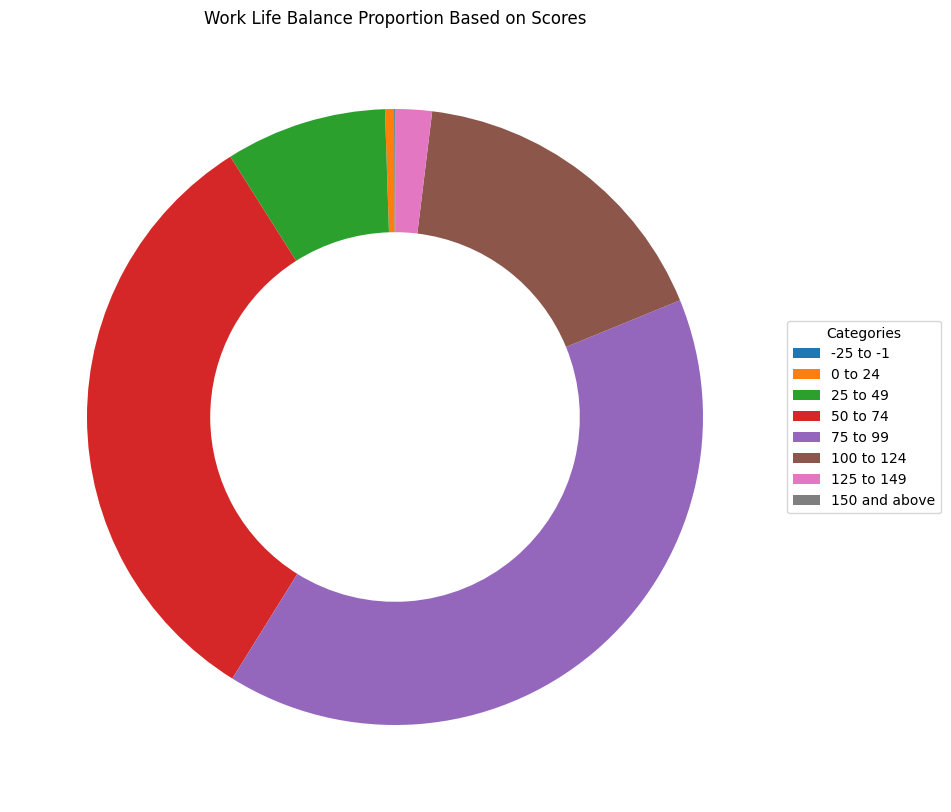

In [ ]:
# Plotting a piechart
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    bucket_counts_pandas["count"],
    autopct="",
    startangle=90,
    wedgeprops=dict(width=0.4),
    textprops=dict(size=10))

ax.legend(work_life_balance_score_list, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Work Life Balance Proportion Based on Scores")
plt.show()

### **3.2**

**Which employees need personal attention?**

As seen above, a large part of employee chunk belongs to the 50-74 range. As per our expertise, these are the employees which have the most potential to improve their work life balance and contribute the most towards the organization. We'll identify these employees with their employee ID and the organization can then carry out the necessary steps.

(filtering the scores < 6 using SQL for the following categories: ACHIEVEMENT, TODO_COMPLETED, SUPPORTING_OTHERS, DAILY_STEPS, WEEKLY_MEDITATION)

In [ ]:
# SQL query to filter out necessary employee IDs
no_of_employees_with_high_potential = final_data.filter((final_data['WORK_LIFE_BALANCE_SCORE'] <= 74) &
 (final_data['WORK_LIFE_BALANCE_SCORE'] >= 50) &
 (final_data['TODO_COMPLETED'] < 6) &
 (final_data['SUPPORTING_OTHERS'] < 6) &
 (final_data['DAILY_STEPS'] < 6) &
 (final_data['WEEKLY_MEDITATION'] < 6) &
 (final_data['ACHIEVEMENT'] < 6)).select('EMPLOYEE_ID','WORK_LIFE_BALANCE_SCORE').count()

print('No of employees having the potential for highest increase in productivity are:', no_of_employees_with_high_potential)

No of employees having the potential for highest increase in productivity are: 695


We identified a significant portion of employees falling within the 50-74 work-life balance score range, highlighting their potential for improvement.
<br>
Visualization through a pie chart offered a clear snapshot of employee distribution across score categories, aiding strategic decision-making.

### **Conclusion**

Through the rigorous methodology outlined above, the MLifeBalance project has successfully identified the top factors influencing work-life balance scores. Leveraging PySpark's Random Forest Classifier and correlation analysis techniques, we uncovered crucial insights into the complex interplay between various factors and individuals' perceptions of work-life harmony.

These insights provide valuable guidance for individuals seeking to enhance their work-life balance and for organizations striving to create supportive environments conducive to employee well-being and productivity.

Furthermore, the project's analysis identified a significant portion of employees falling within the 50-74 work-life balance score range, highlighting their potential for improvement.

Overall, the MLifeBalance project lays a solid foundation for further research and intervention in the crucial domain of work-life balance, with the potential to drive positive outcomes for individuals and organizations alike.

### **Future Scope**

[1] Analyzing factors that cause increased attrition and steps to prevent it <br>
[2] Using ML to predict employee performance based on his / her lifestyle & using that to optimize productivity <br>
[3] Resource Allocation: Output v/s Burnout rate must be studied thoroughly. This will allow organizations to take sound decisions with respect to distribution and allocation of employees on high-stake and not-so-high stake projects. <br>
[4] Integration of real-time data streams to provide dynamic insights into work-life balance trends. <br>
[5] Inclusion of a broader range of demographic variables for deeper insights into diverse experiences. <br>
[6] Integration of sentiment analysis techniques with qualitative data sources for a holistic view. <br>

### **Important Links**

[1] PPT : https://docs.google.com/presentation/d/1xMpKKrKeOqpYXrEuFlMXLvu7oEZJsxldarq-JlfgziQ/edit?usp=sharing <br>
[2] Report : https://docs.google.com/document/d/1iIDdYHSEbLkSeTQZUfR5iPrqU560FCsAgVZ9P8B4EVY/edit?usp=sharing <br>
[3] Dataset : Mentioned in the 'About the Dataset section.